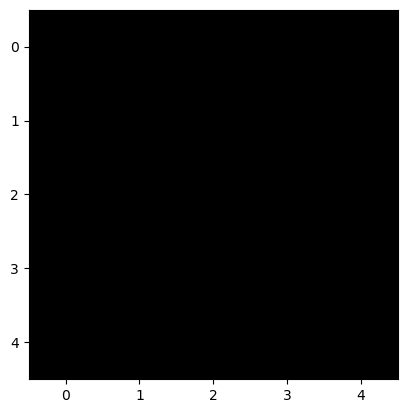

In [1]:
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(np.random.randint(0,1,(5,5,3)))

In [ ]:
# Requires the ele2364 package

import time
import numpy as np
import matplotlib.pyplot as plt

import ele2364
from ele2364 import Memory
from ele2364.environments import Pendulum, FlappyBird, Lander
from ele2364.networks import DQ,V,CQ
from ele2364 import rbfprojector

from train_routines.Active_inference import ActiveInference_trainer
from models.networks import EnsembleModel,RewardModel

In [ ]:
# TODO: Create environment
%matplotlib inline
from random import choice
#from tqdm.notebook import trange, tqdm
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from train_routines.Active_inference import ActiveInference_trainer
from models.networks import EnsembleModel,RewardModel
from models.Agents import Planner
from models.utils import Normalizer,Memory_tensors

env=Pendulum()
Rh=[]


WM=EnsembleModel(in_size=4,hidden_size=100,out_size=3,ensemble_size=3)
RM=RewardModel(in_size=4,hidden_size=100)
DATA=Memory_tensors(ensemble_size=3,state_dims=3, action_dims=1)
#DATA=Memory(3,1)
planner=Planner(
        ensemble=WM,
        reward_model=RM,
        action_size=1,
        ensemble_size=3,
        plan_horizon=30,
        optimisation_iters=7,
        n_candidates=50,
        top_candidates=5,
        batch_size=100,
        learning_rate=1e-3,
        #device="cuda"
        )

random_policy=lambda :np.random.uniform(0,2,(1))
nor=Normalizer()
trainer=ActiveInference_trainer(planner,env,DATA,random_policy,nor,100)

In [ ]:
trainer.train(100)

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

-1201.7395268759458
state prediction loss, reward prediction loss
50.27034206390381 50.000268688201906
-987.1660857096191
state prediction loss, reward prediction loss
48.42270063400269 33.348477334976195


time to train 100 episodes in mean 118.6587 seconds with standard deviation of 9.765
algorithm learned to solve pendulum over -500 rewards consistenly 63.4 episodes in mean with standard deviation of 13.632

# Exercise 3.1

In [23]:
%matplotlib inline
from random import choice
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from ele2364.networks import Pi, V

EPOCHS=80
BATCH_SIZE=2000
GAMMA=0.99
LAMBDA=0.97

def PPO():
    env=Pendulum()

    # TODO: Create network
    Actor=Pi(3,1,lr=3e-4)
    Critic=V(3,lr=1e-3)
    # TODO: Create replay memory
    DATA=Memory(3,1)


    episodes=tqdm(range(1000))
    steps=tqdm(range(1000))
    t=0
    total_reward=0
    T=0
    reward_history=[]
    test_reward_history=[]

    start_time = time.time()
    for e in range(len(episodes)):
        # TODO: Reset environment
        s=env.reset()
        episodes.set_description("last episode time {t:d}, last total reward {tr:f}".format(t=t,tr=total_reward))
        episodes.update()
        total_reward=0

        for step in range(len(steps)):
            # TODO: Select action (exercise 2.2)
            a,logp=Actor.forward(s)
            v=Critic.forward(s)
            sp, r, terminal, truncated, info = env.step(2*a)
            DATA.add(s, a, r, sp, (terminal or truncated), v=v, logp=logp)
            s=sp

            steps.set_description("step {t:d}, exploration {ef:f}, mean loss {l:f}".format(t=step,ef=0.99**e,l=total_reward))
            steps.update()
            total_reward=total_reward+r
            if terminal or truncated:
                reward_history.append(total_reward)
                if e+1==100:
                    end_time = time.time()

                # Generalized Advantage computation
                ep_indx_1= 0 if len(np.where(DATA.terminal==1.0)[0])==1 else np.where(DATA.terminal==1.0)[0][-2]+1
                ep_indx_2= np.where(DATA.terminal==1.0)[0][-1] + 1 if len(np.where(DATA.terminal==1.0)[0])==1 else np.where(DATA.terminal==1.0)[0][-1] + 1
                new_delta_batch,new_adv_batch,new_rtg_batch=np.zeros((ep_indx_2-ep_indx_1,1)),np.zeros((ep_indx_2-ep_indx_1,1)),np.zeros((ep_indx_2-ep_indx_1,1))

                slice=np.arange(ep_indx_1,ep_indx_2)
                T=ep_indx_2-ep_indx_1
                # Gather data
                for t in range(T-1,-1,-1):
                    new_delta_batch[t] = DATA.r[slice][t] + GAMMA * (0 if t+1==T else DATA.v[slice][t+1]) - DATA.v[slice][t]
                    new_adv_batch[t] = GAMMA * LAMBDA * (0 if t+1==T else new_adv_batch[t+1]) + new_delta_batch[t]
                    new_rtg_batch[t] = (DATA.r[slice][t]) if t+1==T else (GAMMA * new_rtg_batch[t+1] + DATA.r[slice][t])

                DATA.adv[slice]=new_adv_batch
                DATA.rtg[slice]=new_rtg_batch


                break
        if (e+1)%10==0 and e>0:
            for epoch in range(EPOCHS):
                rand_idx=np.random.choice(np.arange(len(DATA)),len(DATA))
                s_batch,a_p_batch,logp_batch,adv_batch,rtg_batch=DATA.s[rand_idx],DATA.a[rand_idx],DATA.logp[rand_idx],DATA.adv[rand_idx],DATA.rtg[rand_idx]
                Actor.update(s_batch,a_p_batch,logp_batch,adv_batch)

            for epoch in range(EPOCHS):
                rand_idx=np.random.choice(np.arange(len(DATA)),len(DATA))
                s_batch,a_p_batch,logp_batch,adv_batch,rtg_batch=DATA.s[rand_idx],DATA.a[rand_idx],DATA.logp[rand_idx],DATA.adv[rand_idx],DATA.rtg[rand_idx]
                Critic.update(s_batch,rtg_batch)
            DATA=Memory(3,1)

    window_size = 5
    learn_time = 1000
    for i in range(len(reward_history) - window_size + 1):
        window = reward_history[i:i+window_size]
        if all(r > -500 for r in window):
            learn_time = i + window_size
            break
    
    for e in range(100):
        # TODO: Reset environment
        s=env.reset()
        episodes.update()
        total_reward=0
        
        for t in range(len(steps)):
            a,_=Actor.forward(s)
            sp, r, terminal, truncated, info = env.step(2*a)
            s=sp
            total_reward=total_reward+r
            if terminal or truncated:
                test_reward_history.append(total_reward)
                plt.plot(reward_history)
                break

    env.close()
    return (end_time-start_time),learn_time,test_reward_history,reward_history,Critic,Actor


In [24]:
stat_time_measure,stat_learn_time,stat_test_reward_history,stat_reward_history=[],[],[],[]
for i in range(5):
    time_measure,learn_time,test_reward_history,reward_history,Cr_params,Ac_params=PPO()
    stat_time_measure.append(time_measure)
    stat_learn_time.append(learn_time)
    stat_test_reward_history.append(test_reward_history)
    stat_reward_history.append(reward_history)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

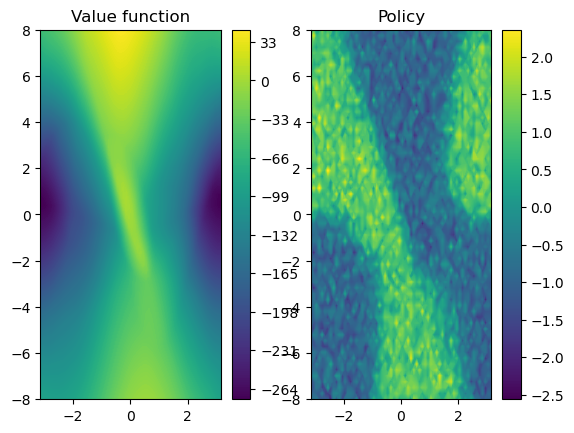

In [29]:
env.plotnetwork(Ac_params,Cr_params)
plt.show()

time to train 100 episodes in mean 95.3593177318573 with standard deviation of 15.204396717468944
algorithm learned to solve pendulum in mean 711.0 with standard deviation of 253.44979779041057


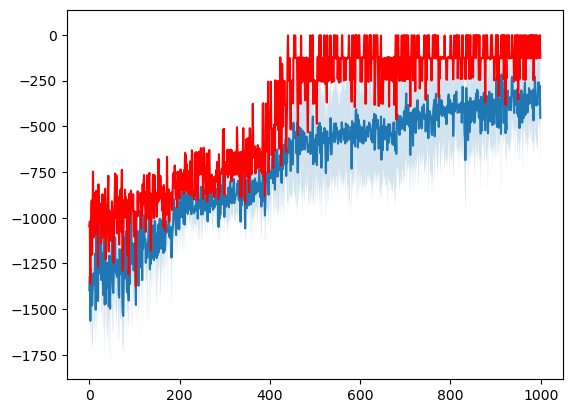

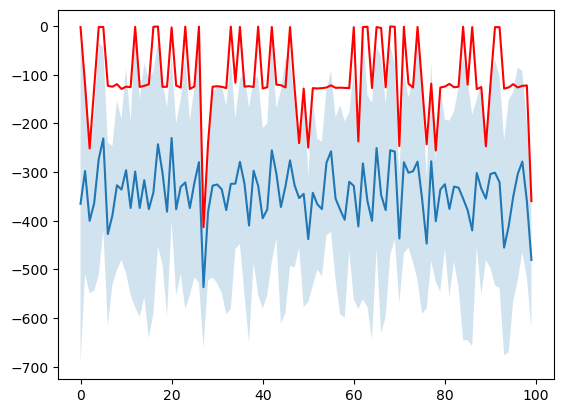

In [26]:
print(f"time to train 100 episodes in mean {np.mean(np.array(stat_time_measure))} with standard deviation of {np.std(np.array(stat_time_measure))}")
print(f"algorithm learned to solve pendulum in mean {np.mean(np.array(stat_learn_time))} with standard deviation of {np.std(np.array(stat_learn_time))}")

r_mean=np.mean(np.array(stat_reward_history),axis=0)
r_std=np.std(np.array(stat_reward_history),axis=0)
fig, ax = plt.subplots()
ax.plot(np.mean(np.array(stat_reward_history),axis=0))
ax.plot(np.max(np.array(stat_reward_history),axis=0),'r')
ax.fill_between(np.arange(len(r_mean)), r_mean - r_std, r_mean + r_std, alpha=0.2)
plt.show()

r_mean=np.mean(np.array(stat_test_reward_history),axis=0)
r_std=np.std(np.array(stat_test_reward_history),axis=0)
fig, ax = plt.subplots()
ax.plot(np.mean(np.array(stat_test_reward_history),axis=0))
ax.plot(np.max(np.array(stat_test_reward_history),axis=0),'r')
ax.fill_between(np.arange(len(r_mean)), r_mean - r_std, r_mean + r_std, alpha=0.2)
plt.show()

time to train 100 episodes in mean 95.35 seconds with standard deviation of 15.20
algorithm learned to solve pendulum over -500 rewards consistenly 711.0 episodes in mean with standard deviation of 53.44

# Exercise 4.1

In [ ]:
%matplotlib inline
from random import choice
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from ele2364.networks import Mu, DQ,ttf

EPOCHS=80
BATCH_SIZE=200
GAMMA=0.99
LAMBDA=0.97

def DDPG():
    env=Pendulum()
    Actor=Mu(3,1)
    Actor_target=Mu(3,1)
    Critic=CQ(3,1)
    Critic_target=CQ(3,1)

    Critic_target.copyfrom(Critic)
    Actor_target.copyfrom(Actor)
    # TODO: Create replay memory
    DATA=Memory(3,1)


    episodes=tqdm(range(150))
    steps=tqdm(range(1000))
    t=0
    total_reward=0
    T=0
    reward_history=[]
    test_reward_history=[]

    start_time = time.time()
    for e in range(len(episodes)):
        # TODO: Reset environment
        s=env.reset()
        episodes.set_description("last episode time {t:d}, last total reward {tr:f}".format(t=t,tr=total_reward))
        episodes.update()
        total_reward=0

        for step in range(len(steps)):
            # TODO: Select action (exercise 2.2)
            a=Actor.forward(s)
            sp, r, terminal, truncated, info = env.step(np.clip(2*a+np.random.randn(1)*0.2,-2,2))
            DATA.add(s, a, r, sp, (terminal or truncated))
            s=sp

            steps.set_description("step {t:d}, exploration {ef:f}, mean loss {l:f}".format(t=step,ef=0.99**e,l=total_reward))
            steps.update()
            total_reward=total_reward+r

            s_batch, a_batch, r_batch, sp_batch, done_batch = DATA.sample(200)
            # Update Critic
            y= r_batch + (1 - done_batch) * GAMMA * Critic_target.forward(sp_batch,Actor_target.forward(sp_batch))

            Critic.update(s=s_batch,a=a_batch,targets=y)
                # Update Actor
            Actor.update(s_batch,Critic)
            #Critic_target.copyfrom(Critic)
            #Actor_target.copyfrom(Actor)
            #Soft update
            for target_param, param in zip(Critic_target.parameters(), Critic.parameters()):
                target_param.data.copy_(target_param.data + 0.01 * (param.data - target_param.data))

            for target_param, param in zip(Actor_target.parameters(), Actor.parameters()):
                target_param.data.copy_(target_param.data + 0.01 * (param.data - target_param.data))


            if terminal or truncated:
                if e+1==100:
                    end_time = time.time()
                reward_history.append(total_reward)

                break

    window_size = 5
    learn_time = 150
    for i in range(len(reward_history) - window_size + 1):
        window = reward_history[i:i+window_size]
        if all(r > -500 for r in window):
            learn_time = i + window_size
            break

    for e in range(100):
        # TODO: Reset environment
        s=env.reset()
        episodes.update()
        total_reward=0

        for t in range(len(steps)):
            a=Actor.forward(s)
            sp, r, terminal, truncated, info = env.step(2*a)
            s=sp
            total_reward=total_reward+r
            if terminal or truncated:
                test_reward_history.append(total_reward)
                break
    # TODO: Close environment
    env.close()
    return (end_time-start_time),learn_time,test_reward_history,reward_history,Critic,Actor


In [11]:
stat_time_measure,stat_learn_time,stat_test_reward_history,stat_reward_history=[],[],[],[]
for i in range(5):
    time_measure,learn_time,test_reward_history,reward_history,Cr_params,Ac_params=DDPG()
    stat_time_measure.append(time_measure)
    stat_learn_time.append(learn_time)
    stat_test_reward_history.append(test_reward_history)
    stat_reward_history.append(reward_history)

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

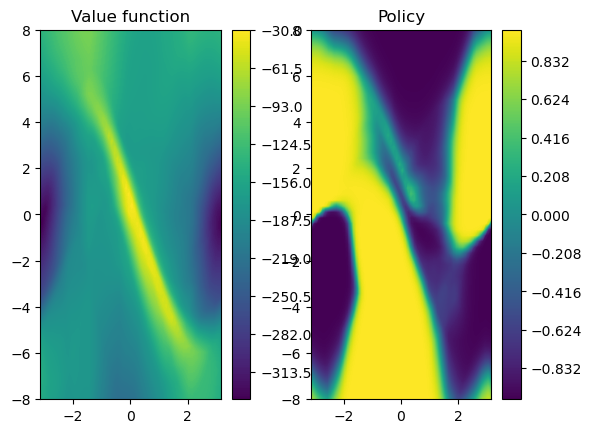

In [22]:
env.plotnetwork(Ac_params,Cr_params)
plt.show()

time to train 100 episodes in mean 294.5236349105835 with standard deviation of 34.09535089650617
algorithm learned to solve pendulum in mean 224.0 with standard deviation of 225.96548408993795


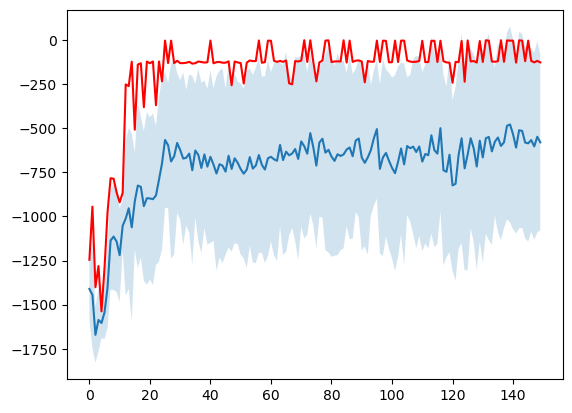

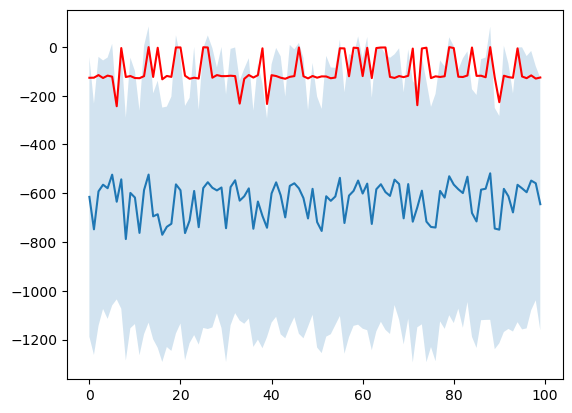

In [20]:
print(f"time to train 100 episodes in mean {np.mean(np.array(stat_time_measure))} with standard deviation of {np.std(np.array(stat_time_measure))}")
print(f"algorithm learned to solve pendulum in mean {np.mean(np.array(stat_learn_time))} with standard deviation of {np.std(np.array(stat_learn_time))}")

r_mean=np.mean(np.array(stat_reward_history),axis=0)
r_std=np.std(np.array(stat_reward_history),axis=0)
fig, ax = plt.subplots()
ax.plot(np.mean(np.array(stat_reward_history),axis=0))
ax.plot(np.max(np.array(stat_reward_history),axis=0),'r')
ax.fill_between(np.arange(len(r_mean)), r_mean - r_std, r_mean + r_std, alpha=0.2)
plt.show()

r_mean=np.mean(np.array(stat_test_reward_history),axis=0)
r_std=np.std(np.array(stat_test_reward_history),axis=0)
fig, ax = plt.subplots()
ax.plot(np.mean(np.array(stat_test_reward_history),axis=0))
ax.plot(np.max(np.array(stat_test_reward_history),axis=0),'r')
ax.fill_between(np.arange(len(r_mean)), r_mean - r_std, r_mean + r_std, alpha=0.2)
plt.show()

time to train 100 episodes in mean 294.52 seconds with standard deviation of 34.09
algorithm learned to solve pendulum over -500 rewards consistenly 224.0 episodes in mean with standard deviation of 225.96

# Summary

# Training plots
LEGEND:
- Blue: mean reward of every episode, with shades for 1 standar deviation,
- Red: Best episode result among all runs
## PPO
### train
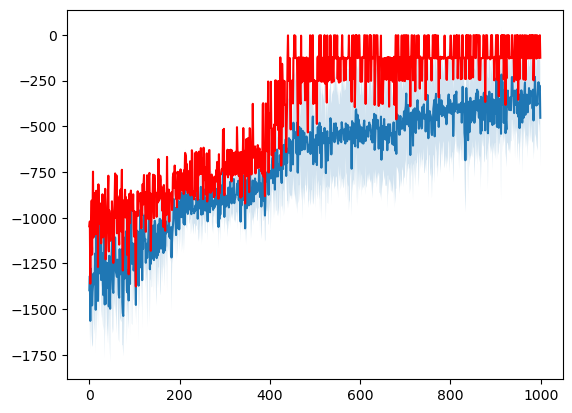
### test
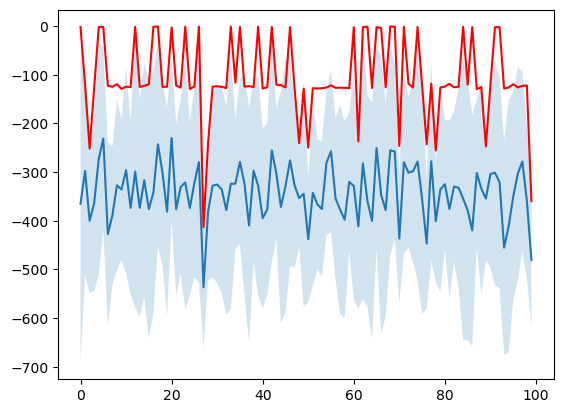
## DDPG
### train
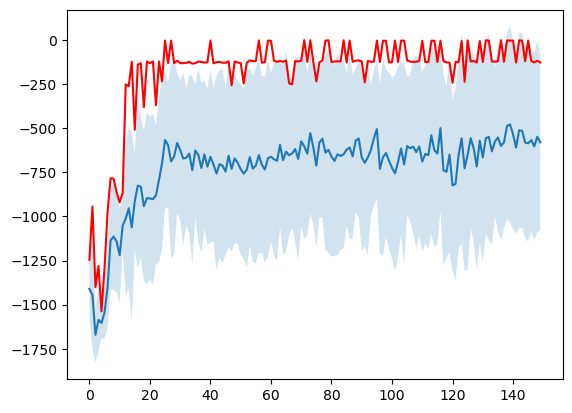
### test
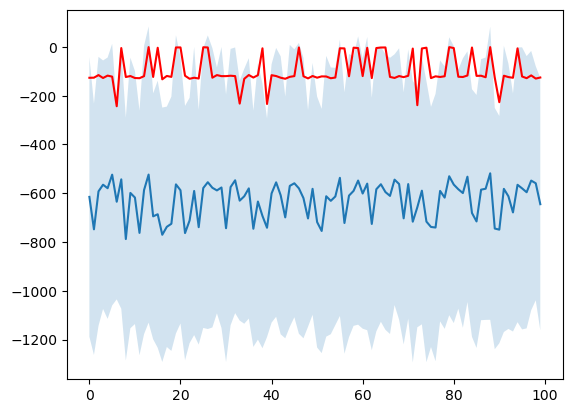
## Linear-action-value-actor-critic
### train
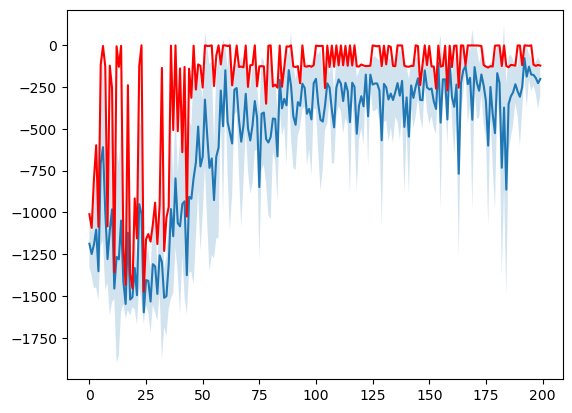
### test
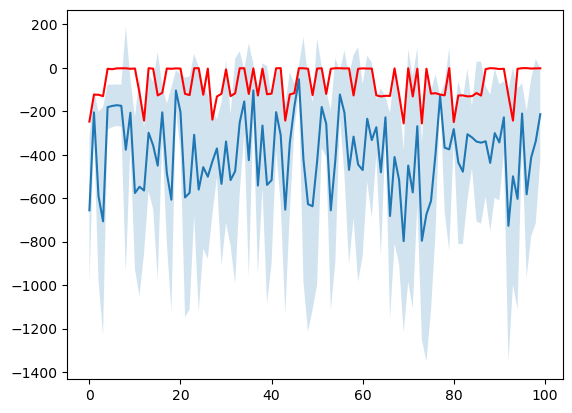



DDPG algorithm is faster in achieving good rewards, however sometimes it fails to converge to a good final result.
after DDPG, Linear action value actor critic achieve better convergence efficiency in terms o episodes and it converges to better results. However it is noisy even after convergence, it mantains this noisy performance at test.
Finally, PPO has very slow convergence episodic efficcientcy, but its results are more robust and with less deviation. 

The PPO take advantage of the dataset generated through many episodes, however update the parameters again make the model to take more time to converge to a general solution.
DDPG updates episodically, this creates a high variance in the policy optimization. this is observable in the results in training and testing.

#  Results With 5 runs

# time to train 100 episodes
Linear-action-value-actor-critic

- Linear-action-value-actor-critic: $\mu=118.65 \ \sigma=9.765$
- Proximal Policy Optimization: $\mu=95.35 \ \sigma=15.20$
- Deep Deterministic Policy Gradient: $\mu=29.52 \ \sigma=34.09$

# algorithm learned to solve pendulum over -500 rewards consistenly
Linear-action-value-actor-critic

- Linear-action-value-actor-critic: $\mu=64.3 \ \sigma=13.63$
- Proximal Policy Optimization: $\mu=711.0 \ \sigma=253.44$
- Deep Deterministic Policy Gradient: $\mu=224.0 \ \sigma=225.96$


#  Results With 10 runs (this are in ex4_sol copy.ipynb)

# time to train 100 episodes
Linear-action-value-actor-critic

- Linear-action-value-actor-critic: $\mu=61.10 \ \sigma=1.87$

- Deep Deterministic Policy Gradient: $\mu=254.80 \ \sigma=44.85$

# algorithm learned to solve pendulum over -500 rewards consistenly
Linear-action-value-actor-critic

- Linear-action-value-actor-critic: $\mu=71.3 \ \sigma=20.38$

- Deep Deterministic Policy Gradient: $\mu=67.3 \ \sigma=54.31$